# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Answer: 
This is a supervised regression problem where the goal is to predict used car prices from vehicle features (year, mileage, make, condition, etc.) and identify which features have the greatest impact on price.
Approach:
Build and compare multiple regression models (Linear, Ridge, Lasso, Random Forest, Gradient Boosting)
Use cross-validation and metrics (R², RMSE, MAE) to evaluate performance
Interpret feature importances/coefficients to determine key price drivers
Provide data-driven recommendations on which vehicle attributes maximize resale value

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [106]:
import numpy as np
import pandas as pd
from statsmodels.tsa import arima_process
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
warnings.filterwarnings("ignore")

In [82]:
vehiclesDf = pd.read_csv('data/vehicles.csv')

In [83]:
vehiclesDf.head()
vehiclesDf.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [84]:

vehiclesDf.describe()
vehiclesDf.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [85]:
vehiclesDf['condition'].unique()

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [86]:
vehiclesDf['type'].unique()

array([nan, 'pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
       'wagon'], dtype=object)

In [87]:
null_summary = pd.DataFrame({
    'null_count': vehiclesDf.isnull().sum(),
    'null_percentage': (vehiclesDf.isnull().sum() / len(vehiclesDf)) * 100
})
null_summary = null_summary.sort_values('null_percentage', ascending=False)

# Display results
print(null_summary)

              null_count  null_percentage
size              306361        71.767476
cylinders         177678        41.622470
condition         174104        40.785232
VIN               161042        37.725356
drive             130567        30.586347
paint_color       130203        30.501078
type               92858        21.752717
manufacturer       17646         4.133714
title_status        8242         1.930753
model               5277         1.236179
odometer            4400         1.030735
fuel                3013         0.705819
transmission        2556         0.598763
year                1205         0.282281
id                     0         0.000000
region                 0         0.000000
price                  0         0.000000
state                  0         0.000000


In [88]:
manufacturerCounts = vehiclesDf[vehiclesDf['manufacturer']\
        .notna()]\
        .groupby(['model','type'])['manufacturer']\
        .nunique()\
        .sort_values(ascending=False)
print(f"Total models with multiple manufacturers: {len(manufacturerCounts)}")
print("\nModels with multiple manufacturers:")
print(manufacturerCounts)

Total models with multiple manufacturers: 26577

Models with multiple manufacturers:
model        type       
van          van            9
truck        pickup         8
coupe        coupe          8
pickup       pickup         8
convertible  convertible    8
                           ..
elantra      sedan          1
             other          1
             hatchback      1
             coupe          1
♿ vmi        mini-van       1
Name: manufacturer, Length: 26577, dtype: int64


In [89]:
# APPROACH 1: Using only MODEL
model_only_mapping = vehiclesDf[vehiclesDf['manufacturer'].notna()]\
    .groupby('model')['manufacturer']\
    .nunique()

# Only use models with exactly 1 manufacturer
reliable_model_only = model_only_mapping[model_only_mapping == 1].index
model_to_manufacturer_v1 = vehiclesDf[
    (vehiclesDf['manufacturer'].notna()) & 
    (vehiclesDf['model'].isin(reliable_model_only))
].groupby('model')['manufacturer'].first()

print("=== APPROACH 1: Model Only ===")
print(f"Unique models with single manufacturer: {len(model_to_manufacturer_v1)}")
print(f"Models with multiple manufacturers (excluded): {len(model_only_mapping[model_only_mapping > 1])}")

# Count how many nulls this would fill
null_manufacturers = vehiclesDf['manufacturer'].isnull()
can_fill_v1 = vehiclesDf[null_manufacturers]['model'].isin(model_to_manufacturer_v1.index).sum()
print(f"Null manufacturers that can be filled: {can_fill_v1} out of {null_manufacturers.sum()}")
print(f"Coverage: {can_fill_v1/null_manufacturers.sum()*100:.2f}%\n")

# APPROACH 2: Using MODEL + TYPE
model_type_mapping = vehiclesDf[vehiclesDf['manufacturer'].notna()]\
    .groupby(['model', 'type'])['manufacturer']\
    .nunique()

# Only use model+type combinations with exactly 1 manufacturer
reliable_model_type = model_type_mapping[model_type_mapping == 1].index
model_type_to_manufacturer_v2 = vehiclesDf[
    (vehiclesDf['manufacturer'].notna()) & 
    (vehiclesDf[['model', 'type']].apply(tuple, axis=1).isin(reliable_model_type))
].groupby(['model', 'type'])['manufacturer'].first()

print("=== APPROACH 2: Model + Type ===")
print(f"Unique (model, type) pairs with single manufacturer: {len(model_type_to_manufacturer_v2)}")
print(f"(model, type) pairs with multiple manufacturers (excluded): {len(model_type_mapping[model_type_mapping > 1])}")

# Count how many nulls this would fill
# Need to check if both model AND type are available for null manufacturers
can_fill_v2_mask = (vehiclesDf['manufacturer'].isnull()) & \
                    (vehiclesDf['type'].notna()) & \
                    (vehiclesDf[['model', 'type']].apply(tuple, axis=1).isin(model_type_to_manufacturer_v2.index))
can_fill_v2 = can_fill_v2_mask.sum()
print(f"Null manufacturers that can be filled: {can_fill_v2} out of {null_manufacturers.sum()}")
print(f"Coverage: {can_fill_v2/null_manufacturers.sum()*100:.2f}%\n")

# COMPARISON
print("=== COMPARISON ===")
print(f"Difference in coverage: {can_fill_v2 - can_fill_v1} rows")
print(f"Percentage point difference: {(can_fill_v2/null_manufacturers.sum()*100) - (can_fill_v1/null_manufacturers.sum()*100):.2f}%")
print(f"\nModel+Type gives {'MORE' if can_fill_v2 > can_fill_v1 else 'LESS'} coverage")

=== APPROACH 1: Model Only ===
Unique models with single manufacturer: 23474
Models with multiple manufacturers (excluded): 273
Null manufacturers that can be filled: 541 out of 17646
Coverage: 3.07%

=== APPROACH 2: Model + Type ===
Unique (model, type) pairs with single manufacturer: 26397
(model, type) pairs with multiple manufacturers (excluded): 180
Null manufacturers that can be filled: 244 out of 17646
Coverage: 1.38%

=== COMPARISON ===
Difference in coverage: -297 rows
Percentage point difference: -1.68%

Model+Type gives LESS coverage


Given the above:
- We would need to drop rows that contain a null model as it can't be inferred from anyting else
- The VIN appears unnecessary - should be unique per vehicle, so the column can be dropped
- The size column seems to be very sparsely populated, so rather than inferring, we should probably just drop the column
- The paint color has a reasonable number of nulls, we can start by setting nulls to 'unknown' - uncertain as to it's usefulness for predicting.
- We could try imputing values for manufacturer and type using model names
- Then impute Drive from type/manufacturer
- We could then impute cylinders and fuel using manufacturer/model/year.
- We could drop the rows where odometer is null - as there is no clear way to impute the values here.
- Perhaps we need a column where we can group odometer into low, medium, high based on model types?
- Set null condition values to unknown.  While we could discern this using mileage and year, condition also is impacted by how well the vehicle was maintained, so shouldn't set a value here

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [90]:
# Make a copy to preserve original data
vehiclesDf_clean = vehiclesDf.copy()

# 1. Drop rows where model is null (can't be inferred)
print(f"Rows before dropping null models: {len(vehiclesDf_clean)}")
vehiclesDf_clean = vehiclesDf_clean.dropna(subset=['model'])
print(f"Rows after dropping null models: {len(vehiclesDf_clean)}")

# 2. Drop VIN column (unnecessary - unique identifier)
vehiclesDf_clean = vehiclesDf_clean.drop(columns=['VIN'])

# 3. Drop size column (71% missing - too sparse)
vehiclesDf_clean = vehiclesDf_clean.drop(columns=['size'])

# 4. Set paint_color nulls to 'unknown'
vehiclesDf_clean['paint_color'] = vehiclesDf_clean['paint_color'].fillna('unknown')

# 5. Impute manufacturer using model names
model_to_manufacturer = vehiclesDf_clean[vehiclesDf_clean['manufacturer'].notna()] \
    .groupby('model')['manufacturer']\
    .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
vehiclesDf_clean['manufacturer'] = vehiclesDf_clean.apply(
    lambda row: model_to_manufacturer.get(row['model'], row['manufacturer']) 
    if pd.isna(row['manufacturer']) else row['manufacturer'],
    axis=1
)
print(f"Manufacturers still missing: {vehiclesDf_clean['manufacturer'].isnull().sum()}")

# 6. Impute type using model names
model_to_type = vehiclesDf_clean[vehiclesDf_clean['type'].notna()].groupby('model')['type'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
vehiclesDf_clean['type'] = vehiclesDf_clean.apply(
    lambda row: model_to_type.get(row['model'], row['type']) 
    if pd.isna(row['type']) else row['type'],
    axis=1
)
print(f"Types still missing: {vehiclesDf_clean['type'].isnull().sum()}")

# 7. Impute drive from type/manufacturer
type_manufacturer_to_drive = vehiclesDf_clean[vehiclesDf_clean['drive'].notna()].groupby(['type', 'manufacturer'])['drive'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
vehiclesDf_clean['drive'] = vehiclesDf_clean.apply(
    lambda row: type_manufacturer_to_drive.get((row['type'], row['manufacturer']), row['drive']) 
    if pd.isna(row['drive']) and pd.notna(row['type']) and pd.notna(row['manufacturer']) else row['drive'],
    axis=1
)
print(f"Drive still missing: {vehiclesDf_clean['drive'].isnull().sum()}")

# 8. Impute cylinders using manufacturer/model/year
manufacturer_model_to_cylinders = vehiclesDf_clean[vehiclesDf_clean['cylinders'].notna()].groupby(['manufacturer', 'model'])['cylinders'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
vehiclesDf_clean['cylinders'] = vehiclesDf_clean.apply(
    lambda row: manufacturer_model_to_cylinders.get((row['manufacturer'], row['model']), row['cylinders']) 
    if pd.isna(row['cylinders']) and pd.notna(row['manufacturer']) and pd.notna(row['model']) else row['cylinders'],
    axis=1
)
print(f"Cylinders still missing: {vehiclesDf_clean['cylinders'].isnull().sum()}")

# 9. Impute fuel using manufacturer/model
manufacturer_model_to_fuel = vehiclesDf_clean[vehiclesDf_clean['fuel'].notna()].groupby(['manufacturer', 'model'])['fuel'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
vehiclesDf_clean['fuel'] = vehiclesDf_clean.apply(
    lambda row: manufacturer_model_to_fuel.get((row['manufacturer'], row['model']), row['fuel']) 
    if pd.isna(row['fuel']) and pd.notna(row['manufacturer']) and pd.notna(row['model']) else row['fuel'],
    axis=1
)
print(f"Fuel still missing: {vehiclesDf_clean['fuel'].isnull().sum()}")

# 10. Drop rows where odometer is null (can't reliably impute)
print(f"Rows before dropping null odometer: {len(vehiclesDf_clean)}")
vehiclesDf_clean = vehiclesDf_clean.dropna(subset=['odometer'])
print(f"Rows after dropping null odometer: {len(vehiclesDf_clean)}")

# 11. Create odometer category column (low/medium/high by type)
# Calculate quartiles by type
odometer_ranges = vehiclesDf_clean.groupby('type')['odometer'].quantile([0.33, 0.67]).unstack()

def categorize_odometer(row):
    if pd.isna(row['type']) or row['type'] not in odometer_ranges.index:
        # Use overall quartiles if type is missing
        overall_low = vehiclesDf_clean['odometer'].quantile(0.33)
        overall_high = vehiclesDf_clean['odometer'].quantile(0.67)
        if row['odometer'] <= overall_low:
            return 'low'
        elif row['odometer'] <= overall_high:
            return 'medium'
        else:
            return 'high'
    else:
        low_thresh = odometer_ranges.loc[row['type'], 0.33]
        high_thresh = odometer_ranges.loc[row['type'], 0.67]
        if row['odometer'] <= low_thresh:
            return 'low'
        elif row['odometer'] <= high_thresh:
            return 'medium'
        else:
            return 'high'

vehiclesDf_clean['odometer_category'] = vehiclesDf_clean.apply(categorize_odometer, axis=1)

# 12. Set null condition values to 'unknown'
vehiclesDf_clean['condition'] = vehiclesDf_clean['condition'].fillna('unknown')

# Summary of remaining nulls
print("\n=== Final Null Summary ===")
null_summary = pd.DataFrame({
    'null_count': vehiclesDf_clean.isnull().sum(),
    'null_percentage': round((vehiclesDf_clean.isnull().sum() / len(vehiclesDf_clean)) * 100, 2)
}).sort_values('null_percentage', ascending=False)
print(null_summary[null_summary['null_count'] > 0])

print(f"\nFinal dataset shape: {vehiclesDf_clean.shape}")

Rows before dropping null models: 426880
Rows after dropping null models: 421603
Manufacturers still missing: 16778
Types still missing: 10219
Drive still missing: 11274
Cylinders still missing: 40803
Fuel still missing: 1625
Rows before dropping null odometer: 421603
Rows after dropping null odometer: 417285

=== Final Null Summary ===
              null_count  null_percentage
cylinders          40449             9.69
manufacturer       16598             3.98
drive              11206             2.69
type               10126             2.43
title_status        7571             1.81
transmission        1679             0.40
fuel                1594             0.38
year                1136             0.27

Final dataset shape: (417285, 17)


In [91]:
vehiclesDf_clean = vehiclesDf_clean[
    (vehiclesDf_clean['price'] > 500) & 
    (vehiclesDf_clean['price'] < 100000)
]
vehiclesDf_final = vehiclesDf_clean.dropna()
vehiclesDf_final.shape

(321375, 17)

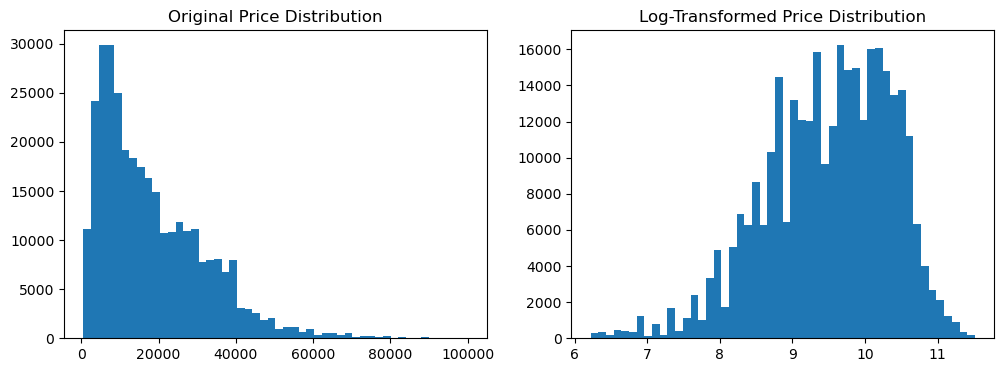

In [92]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(vehiclesDf_final['price'], bins=50)
plt.title('Original Price Distribution')
plt.subplot(1, 2, 2)
plt.hist(np.log1p(vehiclesDf_final['price']), bins=50)
plt.title('Log-Transformed Price Distribution')
plt.show()
vehiclesDf_final['price_log'] = np.log1p(vehiclesDf_final['price'])

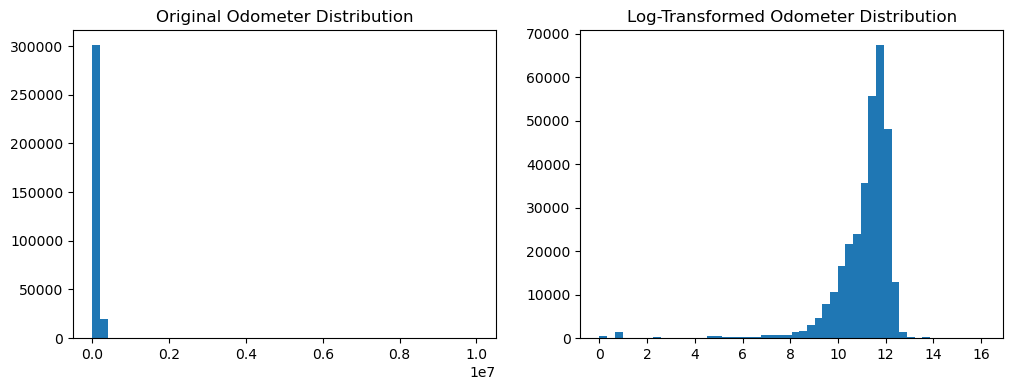

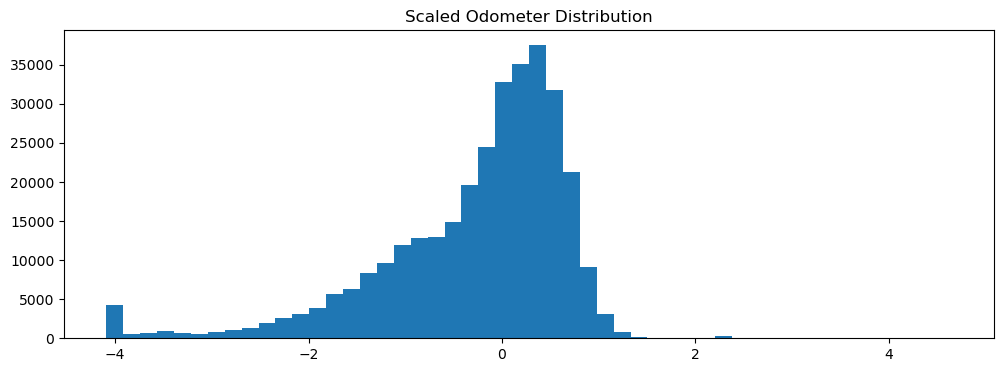

In [96]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(vehiclesDf_final['odometer'], bins=50)
plt.title('Original Odometer Distribution')
plt.subplot(1, 2, 2)
plt.hist(np.log1p(vehiclesDf_final['odometer']), bins=50)
plt.title('Log-Transformed Odometer Distribution')
plt.show()


from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
vehiclesDf_final['odometer_log'] = np.log1p(vehiclesDf_final['odometer'])
vehiclesDf_final['odometer_scaled'] = scaler.fit_transform(vehiclesDf_final[['odometer']])


plt.figure(figsize=(12, 4))
plt.hist(np.log1p(vehiclesDf_final['odometer_scaled']), bins=50)
plt.title('Scaled Odometer Distribution')
plt.show()


In [97]:
# 3. Convert year to age
from datetime import datetime, timezone
current_year = datetime.now(timezone.utc).year
vehiclesDf_final['age'] = current_year - vehiclesDf_final['year']

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [108]:

# ===== 1. PREPARE FEATURES AND TARGET =====
y = vehiclesDf_final['price_log']

# Select features
feature_cols = ['age', 'odometer_log', 'manufacturer', 'condition', 'cylinders', 
                'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']

X = vehiclesDf_final[feature_cols]

print(f"Dataset shape: {X.shape}")
print(f"Target variable: price_log (log-transformed price)")

# ===== 2. SPLIT DATA =====
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ===== 3. CREATE PREPROCESSING PIPELINE =====
numerical_features = ['age', 'odometer_log']
categorical_features = ['manufacturer', 'condition', 'cylinders', 'fuel', 
                        'title_status', 'transmission', 'drive', 'type', 'paint_color']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# ===== 4. DEFINE MODELS (LINEAR ONLY) =====
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=10)': Ridge(alpha=10.0),
    'Ridge (α=100)': Ridge(alpha=100.0),
    'Lasso (α=1.0)': Lasso(alpha=1.0),
    'Lasso (α=10)': Lasso(alpha=10.0)
}

# ===== 5. TRAIN AND EVALUATE MODELS =====
results = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict on all sets
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate MSE and MAE for each set
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation using negative MSE (sklearn convention)
    
    print(f"Train - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")
    print(f"Val   - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")
    print(f"Test  - MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")
    
    results.append({
        'Model': name,
        'Train_MSE': train_mse,
        'Val_MSE': val_mse,
        'Test_MSE': test_mse,
        'Train_RMSE': train_rmse,
        'Val_RMSE': val_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Val_MAE': val_mae,
        'Test_MAE': test_mae,
        'Pipeline': pipeline
    })


Dataset shape: (321375, 11)
Target variable: price_log (log-transformed price)

Train set: 225090 samples
Validation set: 48078 samples
Test set: 48207 samples

Training Linear Regression...
Train - MSE: 0.3514, RMSE: 0.5928, MAE: 0.4040
Val   - MSE: 0.3593, RMSE: 0.5994, MAE: 0.4084
Test  - MSE: 0.3499, RMSE: 0.5916, MAE: 0.4012

Training Ridge (α=1.0)...
Train - MSE: 0.3514, RMSE: 0.5928, MAE: 0.4040
Val   - MSE: 0.3593, RMSE: 0.5994, MAE: 0.4084
Test  - MSE: 0.3499, RMSE: 0.5916, MAE: 0.4012

Training Ridge (α=10)...
Train - MSE: 0.3514, RMSE: 0.5928, MAE: 0.4041
Val   - MSE: 0.3593, RMSE: 0.5994, MAE: 0.4085
Test  - MSE: 0.3500, RMSE: 0.5916, MAE: 0.4012

Training Ridge (α=100)...
Train - MSE: 0.3518, RMSE: 0.5932, MAE: 0.4044
Val   - MSE: 0.3598, RMSE: 0.5998, MAE: 0.4089
Test  - MSE: 0.3504, RMSE: 0.5920, MAE: 0.4017

Training Lasso (α=1.0)...
Train - MSE: 0.7680, RMSE: 0.8764, MAE: 0.7145
Val   - MSE: 0.7767, RMSE: 0.8813, MAE: 0.7186
Test  - MSE: 0.7620, RMSE: 0.8730, MAE: 0.71

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.


MODEL COMPARISON
            Model  Train_MSE  Val_MSE  Test_MSE  Train_MAE  Val_MAE  Test_MAE
Linear Regression   0.351403 0.359255  0.349943   0.404034 0.408425  0.401175
    Ridge (α=1.0)   0.351403 0.359261  0.349945   0.404038 0.408434  0.401183
     Ridge (α=10)   0.351426 0.359311  0.349981   0.404071 0.408497  0.401244
    Ridge (α=100)   0.351844 0.359753  0.350447   0.404406 0.408888  0.401665
    Lasso (α=1.0)   0.768006 0.776722  0.762044   0.714474 0.718620  0.711742
     Lasso (α=10)   0.768006 0.776722  0.762044   0.714474 0.718620  0.711742


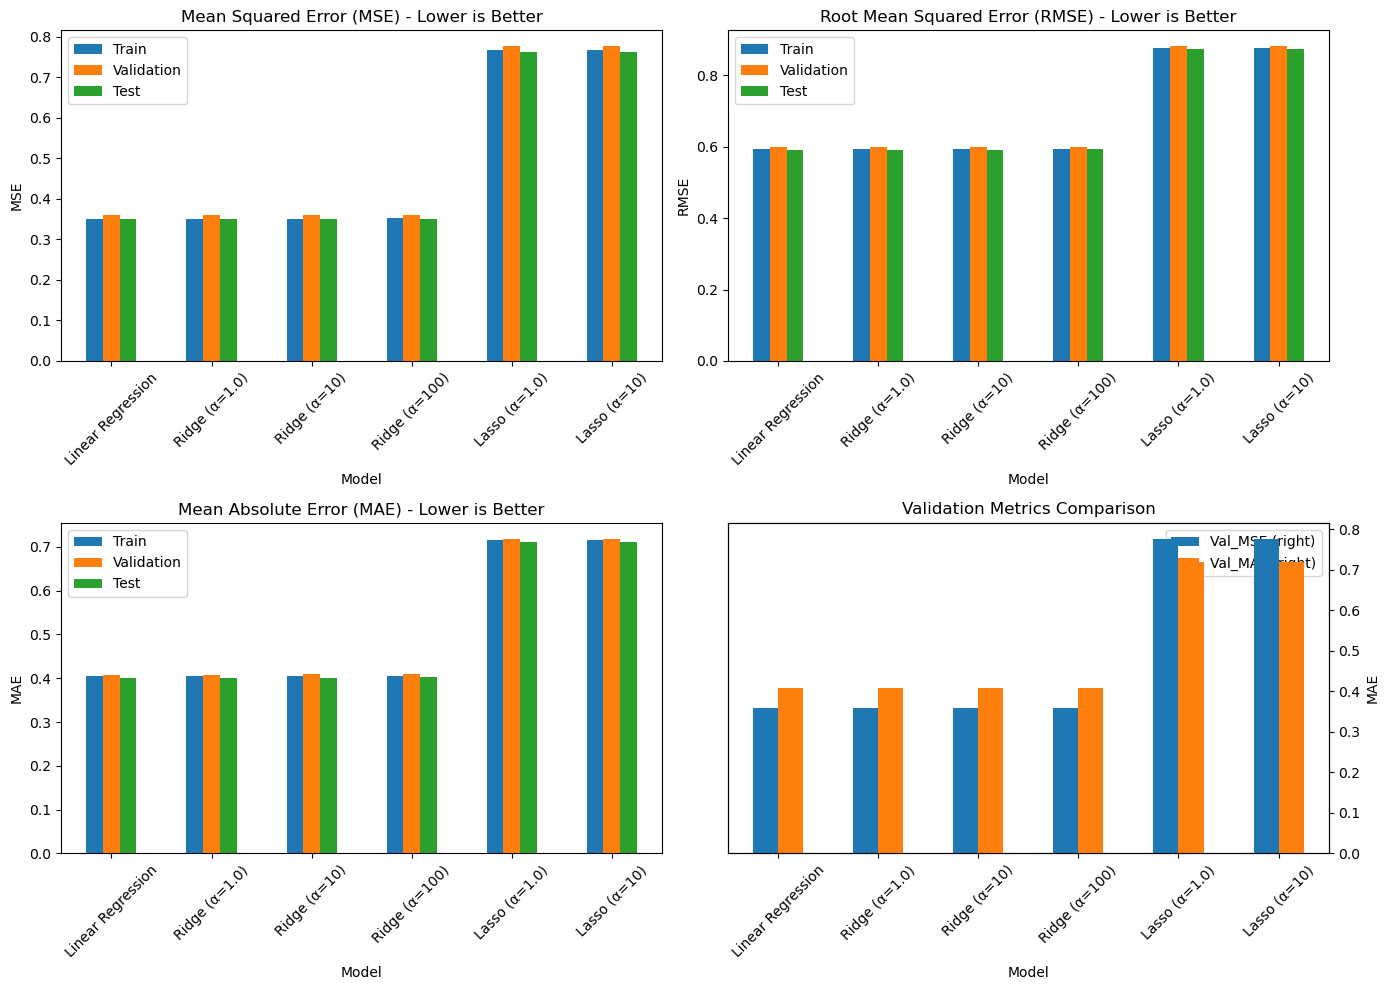


BEST MODEL SELECTION
🏆 Best Model by MSE: Linear Regression
   Validation MSE: 0.3593
   Test MSE: 0.3499

🏆 Best Model by MAE: Linear Regression
   Validation MAE: 0.4084
   Test MAE: 0.4012

FEATURE IMPORTANCE ANALYSIS - Linear Regression


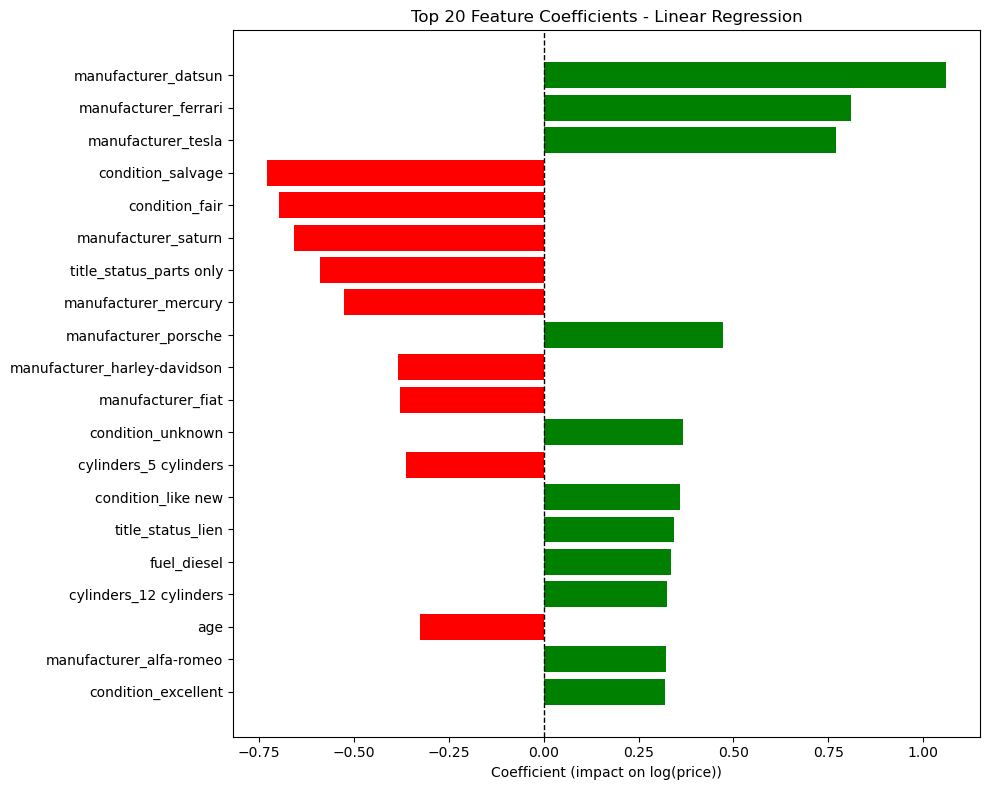


Top 20 Most Important Features:
                     Feature  Coefficient  Abs_Coefficient
         manufacturer_datsun     1.059845         1.059845
        manufacturer_ferrari     0.808839         0.808839
          manufacturer_tesla     0.770031         0.770031
           condition_salvage    -0.729214         0.729214
              condition_fair    -0.696171         0.696171
         manufacturer_saturn    -0.656667         0.656667
     title_status_parts only    -0.589536         0.589536
        manufacturer_mercury    -0.525242         0.525242
        manufacturer_porsche     0.471803         0.471803
manufacturer_harley-davidson    -0.383351         0.383351
           manufacturer_fiat    -0.378315         0.378315
           condition_unknown     0.368102         0.368102
       cylinders_5 cylinders    -0.363353         0.363353
          condition_like new     0.358545         0.358545
           title_status_lien     0.342664         0.342664
                 fuel_d

In [109]:

# ===== 6. COMPARE MODELS =====
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df[['Model', 'Train_MSE', 'Val_MSE', 'Test_MSE', 'Train_MAE', 'Val_MAE', 'Test_MAE']].to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MSE comparison
results_df[['Model', 'Train_MSE', 'Val_MSE', 'Test_MSE']].set_index('Model').plot(
    kind='bar', ax=axes[0, 0], rot=45)
axes[0, 0].set_title('Mean Squared Error (MSE) - Lower is Better')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend(['Train', 'Validation', 'Test'])

# RMSE comparison
results_df[['Model', 'Train_RMSE', 'Val_RMSE', 'Test_RMSE']].set_index('Model').plot(
    kind='bar', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Root Mean Squared Error (RMSE) - Lower is Better')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].legend(['Train', 'Validation', 'Test'])

# MAE comparison
results_df[['Model', 'Train_MAE', 'Val_MAE', 'Test_MAE']].set_index('Model').plot(
    kind='bar', ax=axes[1, 0], rot=45)
axes[1, 0].set_title('Mean Absolute Error (MAE) - Lower is Better')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].legend(['Train', 'Validation', 'Test'])

# Validation metrics comparison
results_df[['Model', 'Val_MSE', 'Val_MAE']].set_index('Model').plot(
    kind='bar', ax=axes[1, 1], rot=45, secondary_y=True)
axes[1, 1].set_title('Validation Metrics Comparison')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].right_ax.set_ylabel('MAE')

plt.tight_layout()
plt.show()

# ===== 7. SELECT BEST MODEL =====
# Choose based on lowest validation MSE
best_model_idx_mse = results_df['Val_MSE'].idxmin()
best_model_name_mse = results_df.loc[best_model_idx_mse, 'Model']

# Choose based on lowest validation MAE
best_model_idx_mae = results_df['Val_MAE'].idxmin()
best_model_name_mae = results_df.loc[best_model_idx_mae, 'Model']

print(f"\n{'='*80}")
print("BEST MODEL SELECTION")
print(f"{'='*80}")
print(f"🏆 Best Model by MSE: {best_model_name_mse}")
print(f"   Validation MSE: {results_df.loc[best_model_idx_mse, 'Val_MSE']:.4f}")
print(f"   Test MSE: {results_df.loc[best_model_idx_mse, 'Test_MSE']:.4f}")
print(f"\n🏆 Best Model by MAE: {best_model_name_mae}")
print(f"   Validation MAE: {results_df.loc[best_model_idx_mae, 'Val_MAE']:.4f}")
print(f"   Test MAE: {results_df.loc[best_model_idx_mae, 'Test_MAE']:.4f}")

# Use the model with lowest validation MSE as best overall
best_pipeline = results_df.loc[best_model_idx_mse, 'Pipeline']
best_model_name = best_model_name_mse

# ===== 8. FEATURE IMPORTANCE (COEFFICIENTS) =====
print(f"\n{'='*80}")
print(f"FEATURE IMPORTANCE ANALYSIS - {best_model_name}")
print(f"{'='*80}")

# Get feature names after preprocessing
feature_names = (numerical_features + 
                 list(best_pipeline.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

# Get coefficients
coefficients = best_pipeline.named_steps['model'].coef_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 8))
top_20 = importance_df.head(20)
colors = ['red' if x < 0 else 'green' for x in top_20['Coefficient']]
plt.barh(range(len(top_20)), top_20['Coefficient'], color=colors)
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.title(f'Top 20 Feature Coefficients - {best_model_name}')
plt.xlabel('Coefficient (impact on log(price))')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display top features
print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

print("\n💡 Interpretation:")
print("- Lower MSE/MAE = Better predictions")
print("- Positive coefficients = feature increases price")
print("- Negative coefficients = feature decreases price")
print("- Larger absolute value = stronger impact on price")

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.